# Loads the processed h5 file and plots data

debugging: the pump probe signal looks weird after implementing mpi

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [2]:
# input parameters
run_groups = {
              '28 mm' : [109, 110, 111, 113],
              '35 mm' : [115,116,119,121,122,123],
              '40 mm' : [124,125,126],
              '45 mm' : [127,128,129,131],
              '50 mm' : [133,134,135,136,137],
              '55 mm' : [138,139,140,141,142,143],
              '60 mm' : [146,148],
              '65 mm' : [150,151,152,153,154,155,156]
              }

# analysis parameters
iq_thr = 1.1

### load and analyse data

In [3]:
def analyse_run(run_num, detector_distance = 0.12, energy = 9.5, iq_thr = iq_thr, r_min=20, r_max = 30):
    '''
    loads and analyses a single run
    '''
    
    # load data
    run = discover_run_h5(run_num)[3:-3]
    img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

    # convert q_scale
    q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

    # convert intensity to photon/pix
    Iq /=energy
    i0 /=energy

    # normalise to i0
    Iq_norm = np.zeros(Iq.shape)
    i0_avg = np.average(i0)
    norm = i0/i0_avg
    for i in range(int(nshots)):
        Iq_norm[i]=Iq[i]/norm[i]

    # hits
    metric,hits = find_hits(Iq_norm,threshold=iq_thr)
    hit_rate =len(hits[hits>0])/nshots
    
    # ice
    filter_length = 1      # 1 = filter off
    ice_thr = 1.0          # delta photon/pix/i0
    q_min, q_max = 1.0,4.5 # A-1
    ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, 
                                    filter_length=filter_length, q_min=q_min, q_max=q_max)

    hits *= np.logical_not(ice_hits)

    # pump probe
    hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on)
    
    return q,hit_avg,miss_avg,diff_signal,hit_rate



In [4]:
run_means = {}

for rg in run_groups.keys():
    
    runs = run_groups[rg]

    n = len(runs)
    data = analyse_run(runs[0])
    q = data[0]
    hit = data[1]
    miss = data[2]
    diff = data[3]
    hr = data[4]

    for i in range(1,n):
        data = analyse_run(runs[i])
        hit = np.vstack([hit,data[1]])
        miss = np.vstack([miss,data[2]])
        diff = np.vstack([diff,data[3]])
        hr = np.vstack([hr,data[4]])
    
    run_means[rg] = [ q, hit.mean(0), miss.mean(0), diff.mean(0), hr.mean(0) ]


run0109_droplets_10um_28mm: 18000 shots
run0110_droplets_10um_28mm: 18000 shots
run0111_droplets_10um_28mm: 18000 shots
run0113_droplets_10um_28mm: 18000 shots
run0115_droplets_10um_35mm: 18000 shots
run0116_droplets_10um_35mm: 18000 shots
run0119_droplets_10um_35mm: 18000 shots
run0121_droplets_10um_35mm: 18000 shots
run0122_droplets_10um_35mm: 18000 shots
run0123_droplets_10um_35mm: 18000 shots
run0124_droplets_10um_35mm: 18000 shots
run0125_droplets_10um_40mm: 18000 shots
run0126_droplets_10um_40mm: 18000 shots
run0127_droplets_10um_45mm: 18000 shots
run0128_droplets_10um_45mm: 18000 shots
run0129_droplets_10um_45mm: 18000 shots
run0131_droplets_10um_45mm: 18000 shots
run0133_droplets_10um_50mm: 18000 shots
run0134_droplets_10um_50mm: 18000 shots
run0135_droplets_10um_50mm: 18000 shots
run0136_droplets_10um_50mm: 18000 shots
run0137_droplets_10um_50mm: 18000 shots
run0138_droplets_10um_55mm: 18000 shots
run0139_droplets_10um_55mm: 18000 shots
run0140_droplets_10um_55mm: 18000 shots


../src/analysis.py:68: RuntimeWarning: invalid value encountered in greater
  hits = metric>threshold
../src/analysis.py:82: RuntimeWarning: invalid value encountered in greater
  hits = ( metric > threshold )


run0150_droplets_10um_65mm: 18000 shots
run0151_droplets_10um_65mm: 18000 shots


/sf/bernina/anaconda/4.4.0/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sf/bernina/anaconda/4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


run0152_droplets_10um_65mm: 18000 shots
run0153_droplets_10um_65mm: 18000 shots
run0154_droplets_10um_65mm: 18000 shots
run0155_droplets_10um_65mm: 18000 shots
run0156_droplets_10um_65mm: 18000 shots


### plot

<IPython.core.display.Javascript object>


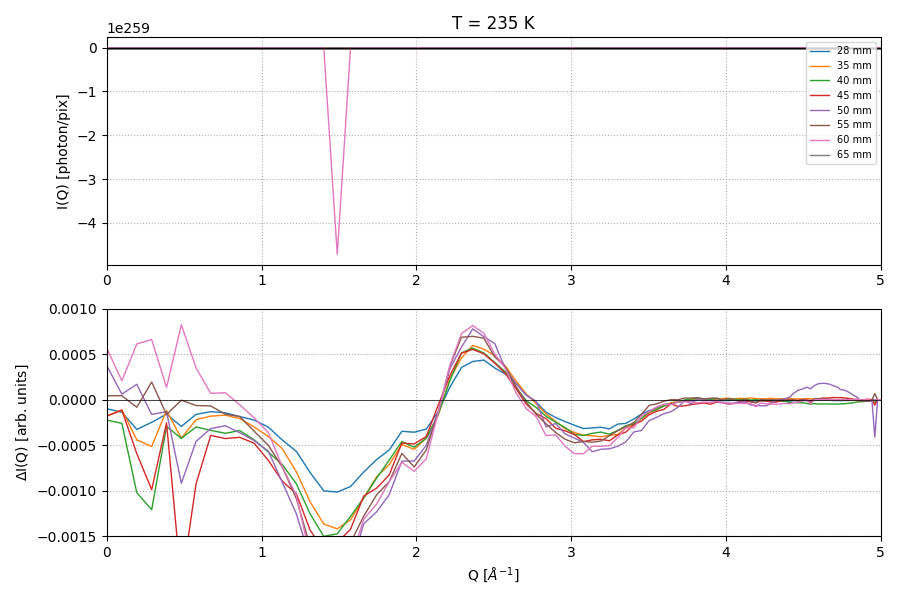

In [5]:
plt.figure(figsize=[9,6])

plt.subplot(2,1,1)
plt.title('T = 235 K')
for rg in run_means.keys():
    hit  = run_means[rg][1]
    miss = run_means[rg][2]
    plt.plot(q, hit - miss, label=rg,lw=1)
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right',fontsize=7)
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')

plt.subplot(2,1,2)
for rg in run_means.keys():
    plt.plot(q, run_means[rg][3], label=rg,lw=1)
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-1.5e-3,1e-3])#plt.figure()
plt.xlabel('Q [$\AA^{-1}$]')
#plt.legend(loc='upper right',fontsize=6)
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=0.5)


plt.tight_layout()
plt.show()